# Computing the overall metrics for different pipelines
We Compare the 8x8 bin, bin2cell, enact and xenium segmentation on visium data using simple summary metrics, for example cell count, transcripts per cell, unassigned transcripts and some more.

In this dataset we use the Visium Dataset published by 10X which demonstrated the Visium post Xenium protocol on Lung Cancer Tissue.
It can be found here: link



For this script, I recommend to use the tmp_enact_analysis environment, the yml file can be found in the environments folder. !!!!!

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

In [2]:

bin_8x8_path = "/srv/gstore/projects/p37785/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2/binned_outputs/square_008um/filtered_feature_bc_matrix.h5"
bin_16x16_path = "/srv/gstore/projects/p37785/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2/binned_outputs/square_016um/filtered_feature_bc_matrix.h5"
cells_b2c_path = "/srv/gstore/projects/p37785/EzPyzBin2CellApp_2025-06-29--17-56-50/Bin2CellApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/cdata.h5ad"
cells_enact_path = "/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--17-57-49/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/chunks/weighted_by_area/celltypist_results/cells_adata.h5"
cells_xseg_path = "/srv/gstore/projects/p1001/EzPyzENACTApp_2025-06-02--15-53-26/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/chunks/weighted_by_area/celltypist_results/cells_adata.h5"


In [3]:
adata_bin_8 = sc.read_h5ad("/srv/gstore/projects/p37785/EzPyzAnndataReportApp_2025-07-23--15-45-57/AnndataReportApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/report/adata_processed.h5ad")
adata_bin_16 = sc.read_10x_h5(bin_16x16_path)
adata_cells_b2c = sc.read_h5ad(cells_b2c_path)
adata_cells_enact = sc.read_h5ad(cells_enact_path)
adata_cells_xseg = sc.read_h5ad(cells_xseg_path)

/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
for name, adata in [
    ('bin_8', adata_bin_8),
    ('bin_16', adata_bin_16),
    ('cells_b2c', adata_cells_b2c),
    ('cells_enact', adata_cells_enact),
    ('cells_xseg', adata_cells_xseg)
]:
    sc.pp.calculate_qc_metrics(adata, inplace=True)

In [5]:
# Prepare data for comparison
datasets = {
    '8x8 bin': adata_bin_8,
    '16x16 bin': adata_bin_16,
    'cells b2c': adata_cells_b2c,
    'cells enact': adata_cells_enact,
    'cells xseg': adata_cells_xseg
}
keys = list(datasets.keys())
cell_keys_p8 = ['8x8 bin', 'cells b2c', 'cells enact', 'cells xseg']
cell_keys = ['cells b2c', 'cells enact', 'cells xseg']
cell_colors = ['gray']*2 + ['tab:blue']*len(cell_keys)

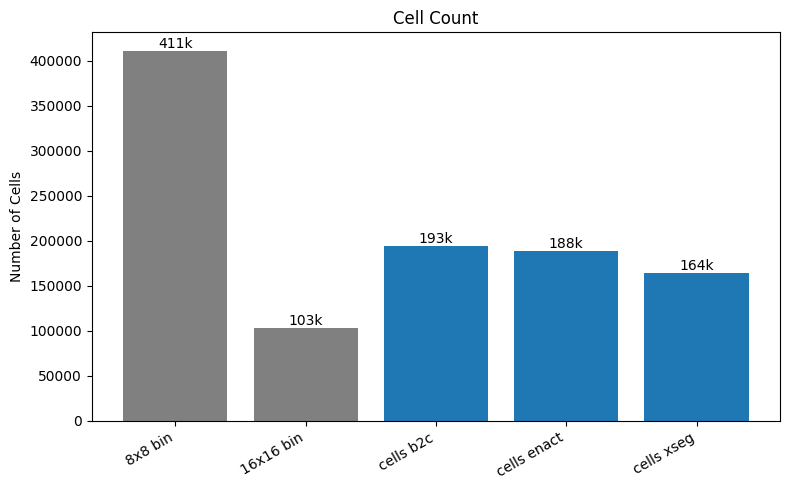

In [6]:
# Plot the number of cells (n_obs) for each dataset
cell_counts = {k: v.n_obs for k, v in datasets.items()}

cell_labels = list(cell_counts.keys())
cell_nums = list(cell_counts.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(cell_labels, cell_nums, color=cell_colors)
plt.ylabel('Number of Cells')
plt.title('Cell Count')
plt.xticks(rotation=30, ha='right')

# Add rounded numbers (in thousands) on top of bars
for bar, num in zip(bars, cell_nums):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{np.floor(num/1000):.0f}k',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [13]:
# Find genes with >0 counts in each dataset
genes_bin_8 = set(adata_bin_8.var_names[(adata_bin_8.X.sum(axis=0) > 0).A1])
genes_b2c = set(adata_cells_b2c.var_names[(adata_cells_b2c.X.sum(axis=0) > 0).A1])
genes_enact = set(adata_cells_enact.var_names[(adata_cells_enact.X.sum(axis=0) > 0).A1])
genes_xseg = set(adata_cells_xseg.var_names[(adata_cells_xseg.X.sum(axis=0) > 0).A1])

not_in_b2c = genes_bin_8 - genes_b2c
not_in_enact = genes_bin_8 - genes_enact
not_in_xseg = genes_bin_8 - genes_xseg

print(f"Genes in bin_8x8 (>0 counts) but not in cells_b2c: {len(not_in_b2c)}")
print(f"Genes in bin_8x8 (>0 counts) but not in cells_enact: {len(not_in_enact)}")
print(f"Genes in bin_8x8 (>0 counts) but not in cells_xseg: {len(not_in_xseg)}")

overlap_all = not_in_b2c & not_in_enact & not_in_xseg
print(f"Genes missing from all cell datasets: {overlap_all}")


Genes in bin_8x8 (>0 counts) but not in cells_b2c: 81
Genes in bin_8x8 (>0 counts) but not in cells_enact: 8
Genes in bin_8x8 (>0 counts) but not in cells_xseg: 13
Genes missing from all cell datasets: {'OR2T27', 'IFNL2', 'VSX1', 'ZP2', 'PRAMEF4', 'PRB4'}


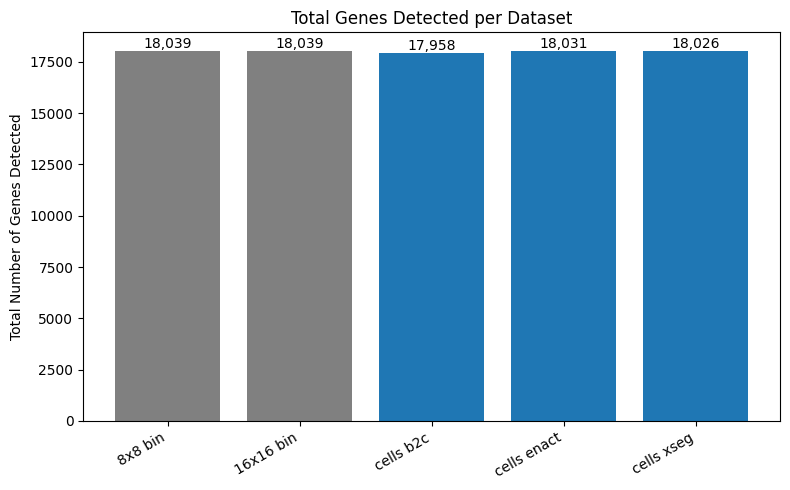

In [8]:
# Calculate total number of genes detected (with at least one count) for each dataset
total_genes_detected = {k: (v.X.sum(axis=0) > 0).sum() for k, v in datasets.items()}

gene_labels = list(total_genes_detected.keys())
gene_nums = list(total_genes_detected.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(gene_labels, gene_nums, color=cell_colors)
plt.ylabel('Total Number of Genes Detected')
plt.title('Total Genes Detected per Dataset')
plt.xticks(rotation=30, ha='right')

# Add actual values above the bars
for bar, num in zip(bars, gene_nums):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{num:,}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [26]:
# For each gene in overlap_all, find the bin_id(s) (index/obs_names) in adata_bin_8 where it was detected (>0)
gene_bin_ids = {}
for gene in overlap_all:
    if gene in adata_bin_8.var_names:
        idx = list(adata_bin_8.var_names).index(gene)
        # Find all bin_ids (obs_names) where this gene has count > 0
        bin_mask = adata_bin_8.X[:, idx].A1 > 0 if hasattr(adata_bin_8.X, "A1") else adata_bin_8.X[:, idx] > 0
        if not isinstance(bin_mask, np.ndarray):
            bin_mask = bin_mask.toarray().flatten()
        gene_x = list(adata_bin_8.obsm['spatial']["cell_x"][bin_mask])
        gene_y = list(adata_bin_8.obsm['spatial']["cell_y"][bin_mask])
        gene_bin_ids[gene] = (gene_x, gene_y)
    else:
        gene_bin_ids[gene] = []

for gene, bins in gene_bin_ids.items():
    print(f"{gene}: {bins}")

OR2T27: ([431], [14])
IFNL2: ([514], [15])
VSX1: ([456], [164])
ZP2: ([637], [286])
PRAMEF4: ([404], [563])
PRB4: ([561], [607])


In [14]:
# Print total counts in the 8x8 dataset for the genes in overlap_all
for gene in overlap_all:
    if gene in adata_bin_8.var_names:
        idx = list(adata_bin_8.var_names).index(gene)
        total = adata_bin_8.X[:, idx].sum()
        print(f"{gene}: {total}")
    else:
        print(f"{gene}: not found in adata_bin_8")

OR2T27: 1.0
IFNL2: 1.0
VSX1: 1.0
ZP2: 1.0
PRAMEF4: 1.0
PRB4: 1.0


/tmp/ipykernel_284926/2559224858.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


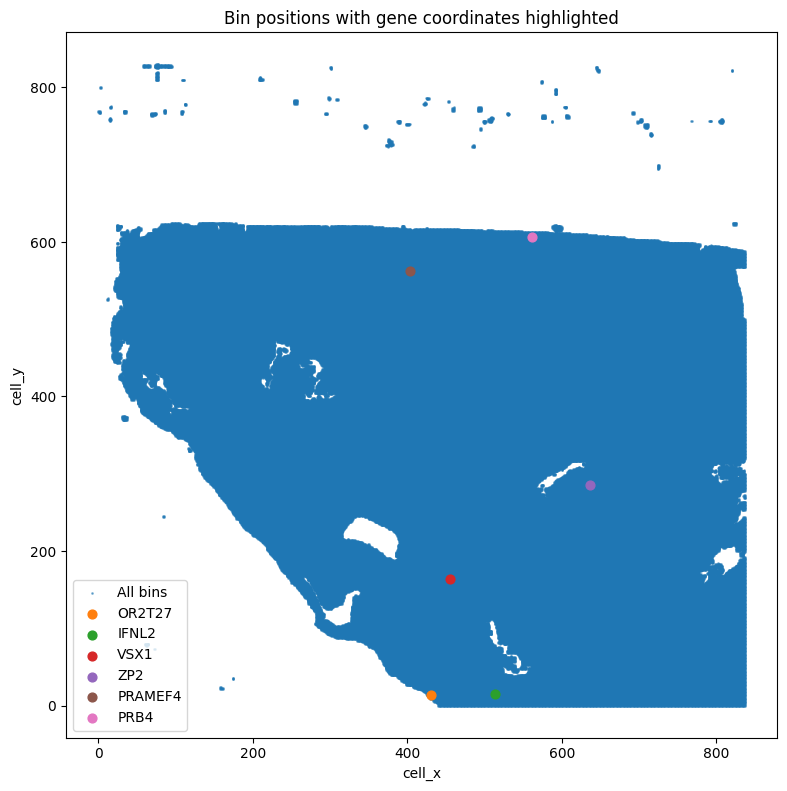

In [28]:
plt.figure(figsize=(8, 8))
# Plot all bin positions
plt.scatter(adata_bin_8.obsm['spatial']["cell_x"], adata_bin_8.obsm['spatial']["cell_y"], s=1, alpha=0.5, label='All bins')
# Overlay gene coordinates from gene_x and gene_y in red
for gene, (gene_x, gene_y) in gene_bin_ids.items():
    plt.scatter(gene_x, gene_y, s=40, label=gene)
plt.xlabel('cell_x')
plt.ylabel('cell_y')
plt.title('Bin positions with gene coordinates highlighted')
plt.legend()
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

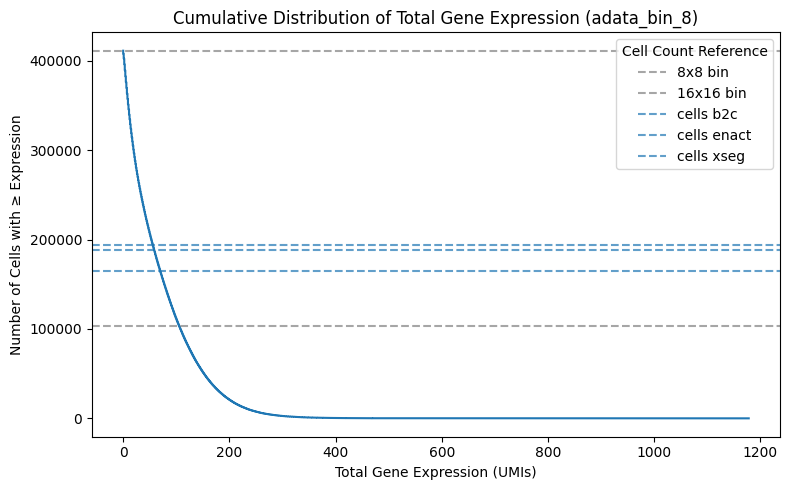

In [29]:
# Plot cumulative distribution of total gene expression for adata_bin_8
total_counts = adata_bin_8.obs['total_counts'].sort_values(ascending=False)
cum_cells = np.arange(1, len(total_counts) + 1)

plt.figure(figsize=(8, 5))
plt.plot(total_counts.values, cum_cells, color='tab:blue')
plt.xlabel('Total Gene Expression (UMIs)')
plt.ylabel('Number of Cells with ≥ Expression')
plt.title('Cumulative Distribution of Total Gene Expression (adata_bin_8)')

# Add horizontal lines at each cell count value, color by label and add legend
for label, count, color in zip(cell_labels, cell_counts.values(), cell_colors):
    plt.axhline(count, color=color, linestyle='--', alpha=0.7, label=label)
plt.legend(title='Cell Count Reference')

plt.tight_layout()
plt.show()

In [30]:
# Find the value of Total Gene Expression (UMIs) where the cumulative curve meets each horizontal cell count line
intersection_values = []
for count in cell_counts.values():
    # Find the index where cum_cells == count (or closest)
    idx = np.searchsorted(cum_cells, count)
    if idx < len(total_counts):
        expr_value = total_counts.values[idx]
    else:
        expr_value = np.nan  # In case count exceeds cum_cells
    intersection_values.append(expr_value)

# Display results
for label, count, expr_value in zip(cell_labels, cell_counts.values(), intersection_values):
    print(f"{label}: Cell count = {count}, Total Gene Expression at intersection = {expr_value:.2f}")

8x8 bin: Cell count = 411242, Total Gene Expression at intersection = 0.00
16x16 bin: Cell count = 103643, Total Gene Expression at intersection = 105.00
cells b2c: Cell count = 193856, Total Gene Expression at intersection = 56.00
cells enact: Cell count = 188596, Total Gene Expression at intersection = 58.00
cells xseg: Cell count = 164273, Total Gene Expression at intersection = 70.00


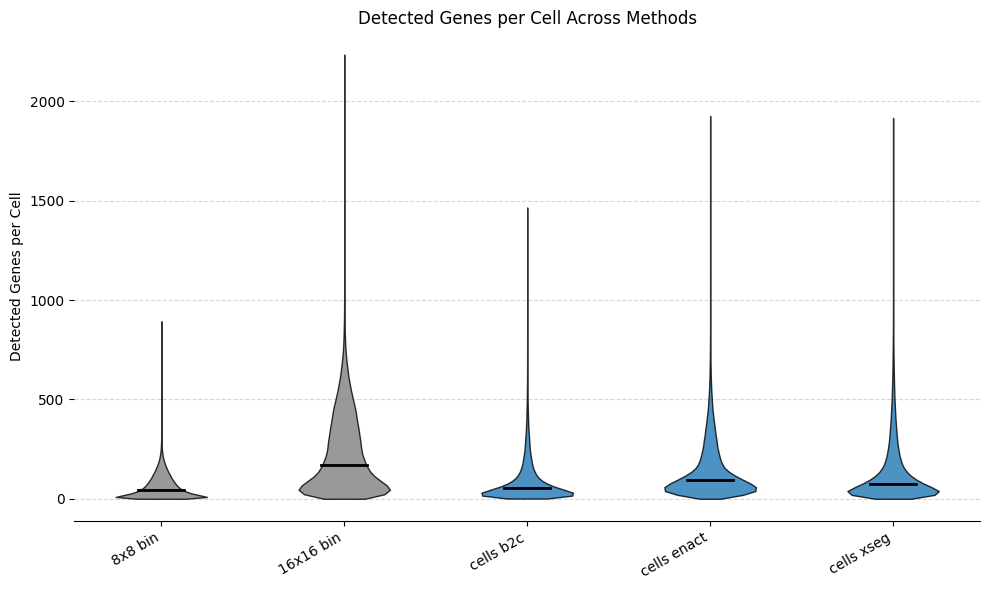

In [34]:
# Prepare data for violin plot: detected genes per cell for each dataset
gene_counts_data = [
    datasets['8x8 bin'].obs['n_genes_by_counts'],
    datasets['16x16 bin'].obs['n_genes_by_counts'],
    datasets['cells b2c'].obs['n_genes_by_counts'],
    datasets['cells enact'].obs['n_genes_by_counts'],
    datasets['cells xseg'].obs['n_genes_by_counts']
]

plt.figure(figsize=(10, 6))
parts = plt.violinplot(
    gene_counts_data,
    showmeans=False,
    showmedians=True,
    showextrema=False
)
# Set median lines to black
for median in parts['cmedians'].get_segments():
    plt.plot(median[:, 0], median[:, 1], color='black', linewidth=2)

# Set custom colors for each violin
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(cell_colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)

# Remove spines and ticks for a cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

plt.xticks(np.arange(1, 6), keys, rotation=30, ha='right')
plt.ylabel('Detected Genes per Cell')
plt.title('Detected Genes per Cell Across Methods')
plt.tight_layout()
plt.show()

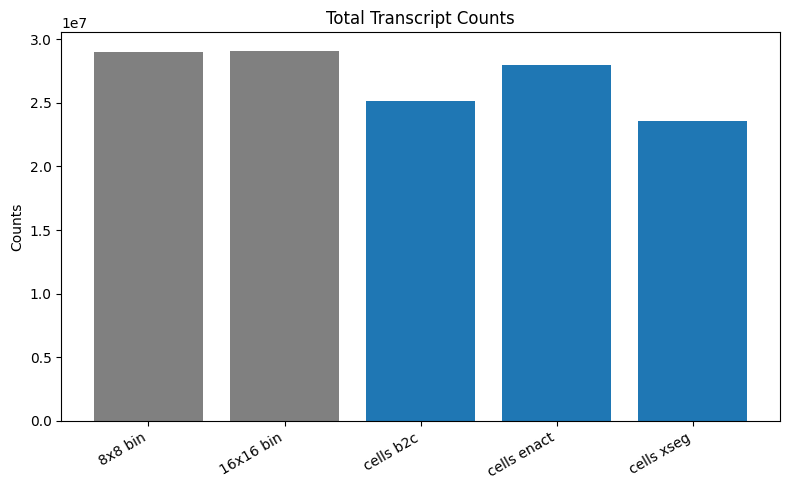

In [35]:
    # Calculate total transcript counts for each dataset
total_counts = {k: v.obs['total_counts'].sum() for k, v in datasets.items()}

# Prepare data for plotting
counts = [total_counts[k] for k in keys]

plt.figure(figsize=(8, 5))
bars = plt.bar(keys, counts, color=cell_colors)
plt.ylabel('Counts')
plt.title('Total Transcript Counts')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

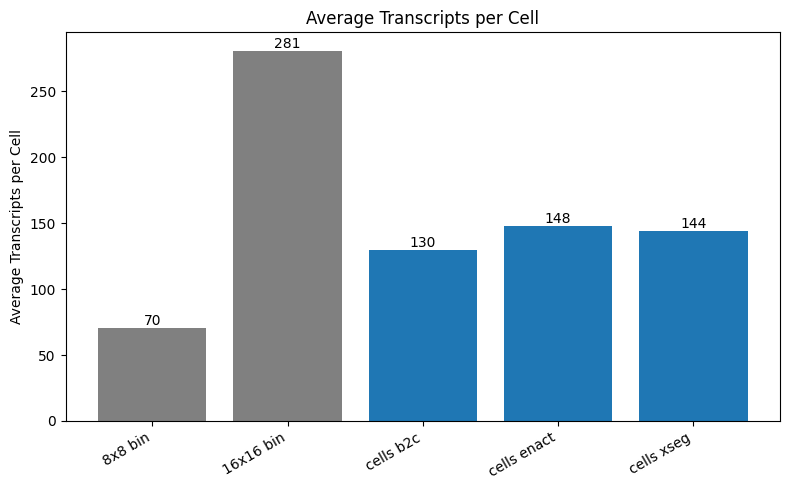

In [12]:
# Calculate average transcripts per cell/nucleus for each dataset
avg_counts = {k: v.obs['total_counts'].mean() for k, v in datasets.items()}


avg_values = [avg_counts[k] for k in keys]

plt.figure(figsize=(8, 5))
bars = plt.bar(keys, avg_values, color=cell_colors, capsize=6)
plt.ylabel('Average Transcripts per Cell')
plt.title('Average Transcripts per Cell')
plt.xticks(rotation=30, ha='right')

# Add actual values above the bars
for bar, val in zip(bars, avg_values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{val:,.0f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

#decided not to show the std because the disrtibution is obviously not normal and as the variance is quite high, it would just distort the plot

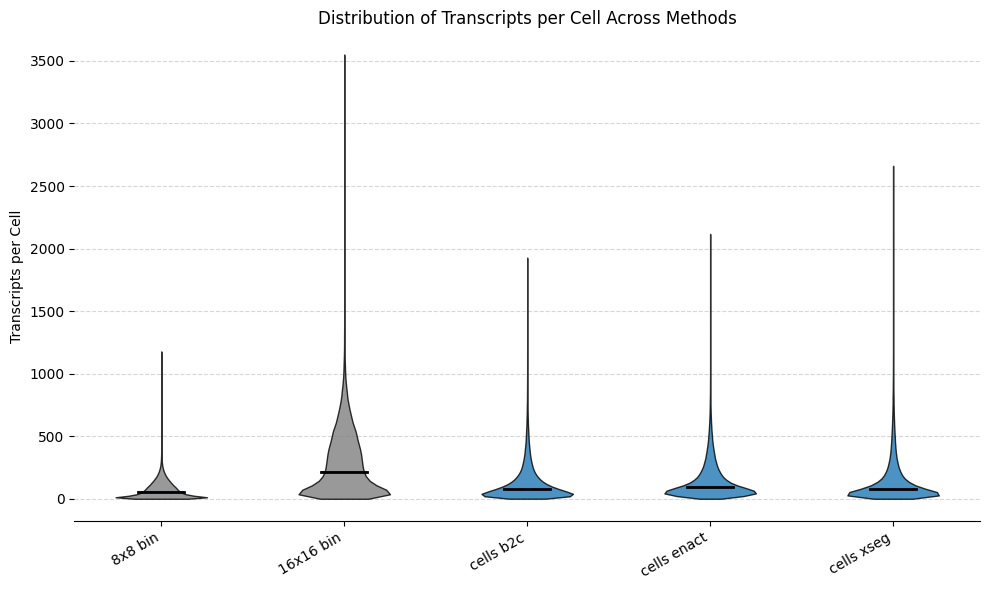

In [39]:
# Violin plot of transcripts per cell for each dataset, with average shown

transcript_counts_data = [
    datasets['8x8 bin'].obs['total_counts'],
    datasets['16x16 bin'].obs['total_counts'],
    datasets['cells b2c'].obs['total_counts'],
    datasets['cells enact'].obs['total_counts'],
    datasets['cells xseg'].obs['total_counts']
]

plt.figure(figsize=(10, 6))
parts = plt.violinplot(
    transcript_counts_data,
    showmeans=False,
    showmedians=True,
    showextrema=False
)

# Set median lines to black
for median in parts['cmedians'].get_segments():
    plt.plot(median[:, 0], median[:, 1], color='black', linewidth=2)

# Set custom colors for each violin
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(cell_colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)

# Remove spines and ticks for a cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

plt.xticks(np.arange(1, 6), keys, rotation=30, ha='right')
plt.ylabel('Transcripts per Cell')
plt.title('Distribution of Transcripts per Cell Across Methods')
plt.tight_layout()
plt.show()

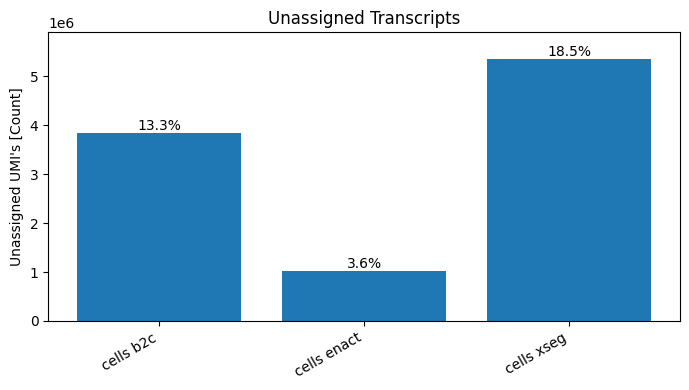

In [13]:
# Calculate unassigned transcripts: difference between bin_8 and each dataset
unassigned_counts = []
unassigned_percents = []
for k in cell_keys:
    diff = total_counts['8x8 bin'] - total_counts[k]
    unassigned_counts.append(diff)
    percent = 100 * diff / total_counts['8x8 bin']
    unassigned_percents.append(percent)

unassigned_labels = cell_keys
unassigned_colors = ['tab:blue']*len(cell_keys)

plt.figure(figsize=(7, 4))
bars = plt.bar(unassigned_labels, unassigned_counts, color=unassigned_colors)
plt.ylabel("Unassigned UMI's [Count]")
plt.title('Unassigned Transcripts')
plt.xticks(rotation=30, ha='right')

# Add space above the highest bar
plt.ylim(top=max(unassigned_counts) * 1.10)

# Overlay percentage labels
for bar, pct in zip(bars, unassigned_percents):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

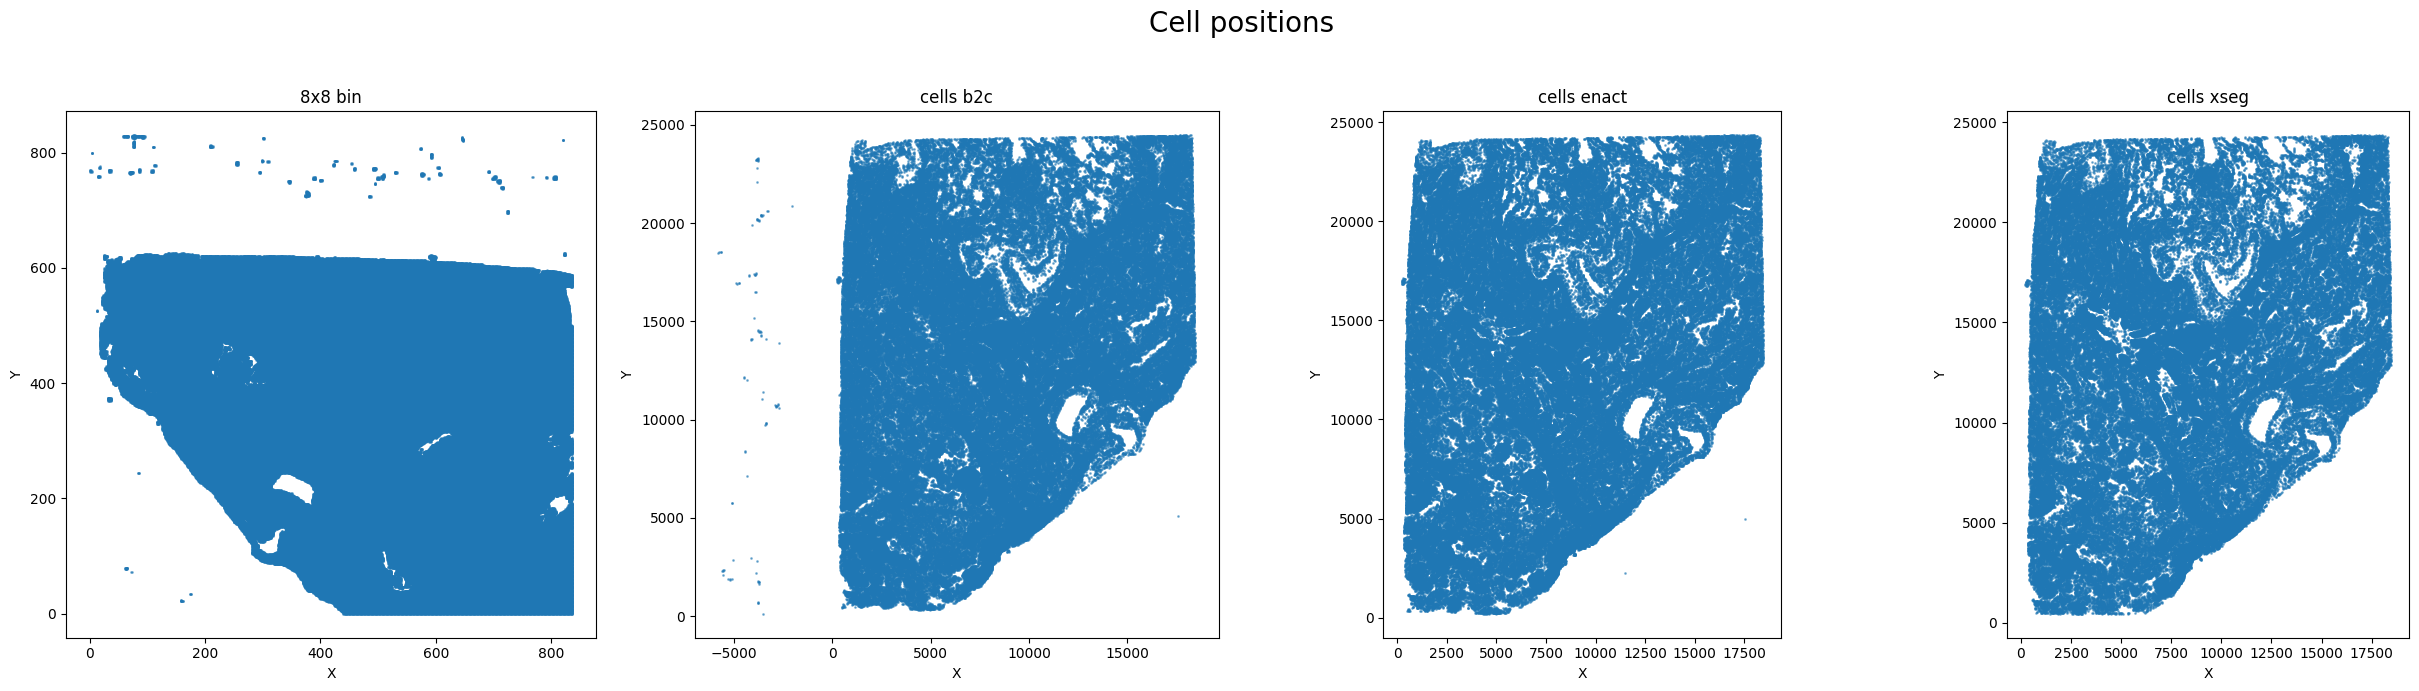

In [16]:
fig, axes = plt.subplots(1, len(cell_keys_p8), figsize=(25, 7), sharex=False, sharey=False)
for ax, key in zip(axes, cell_keys_p8):
    adata = datasets[key]
    coords = adata.obsm['spatial']
    try:
        # Try to use as numpy array (works for AnnData with numpy obsm)
        ax.scatter(coords[:,0], coords[:,1], s=1, alpha=0.5)
    except Exception:
        # If coords is a DataFrame, use column names
        try:
            ax.scatter(coords['cell_x'], coords['cell_y'], s=1, alpha=0.5)
        except Exception:
            # Fallback: try generic .iloc
            ax.scatter(coords.iloc[:,0], coords.iloc[:,1], s=1, alpha=0.5)
    ax.set_title(key)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')
fig.suptitle("Cell positions", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

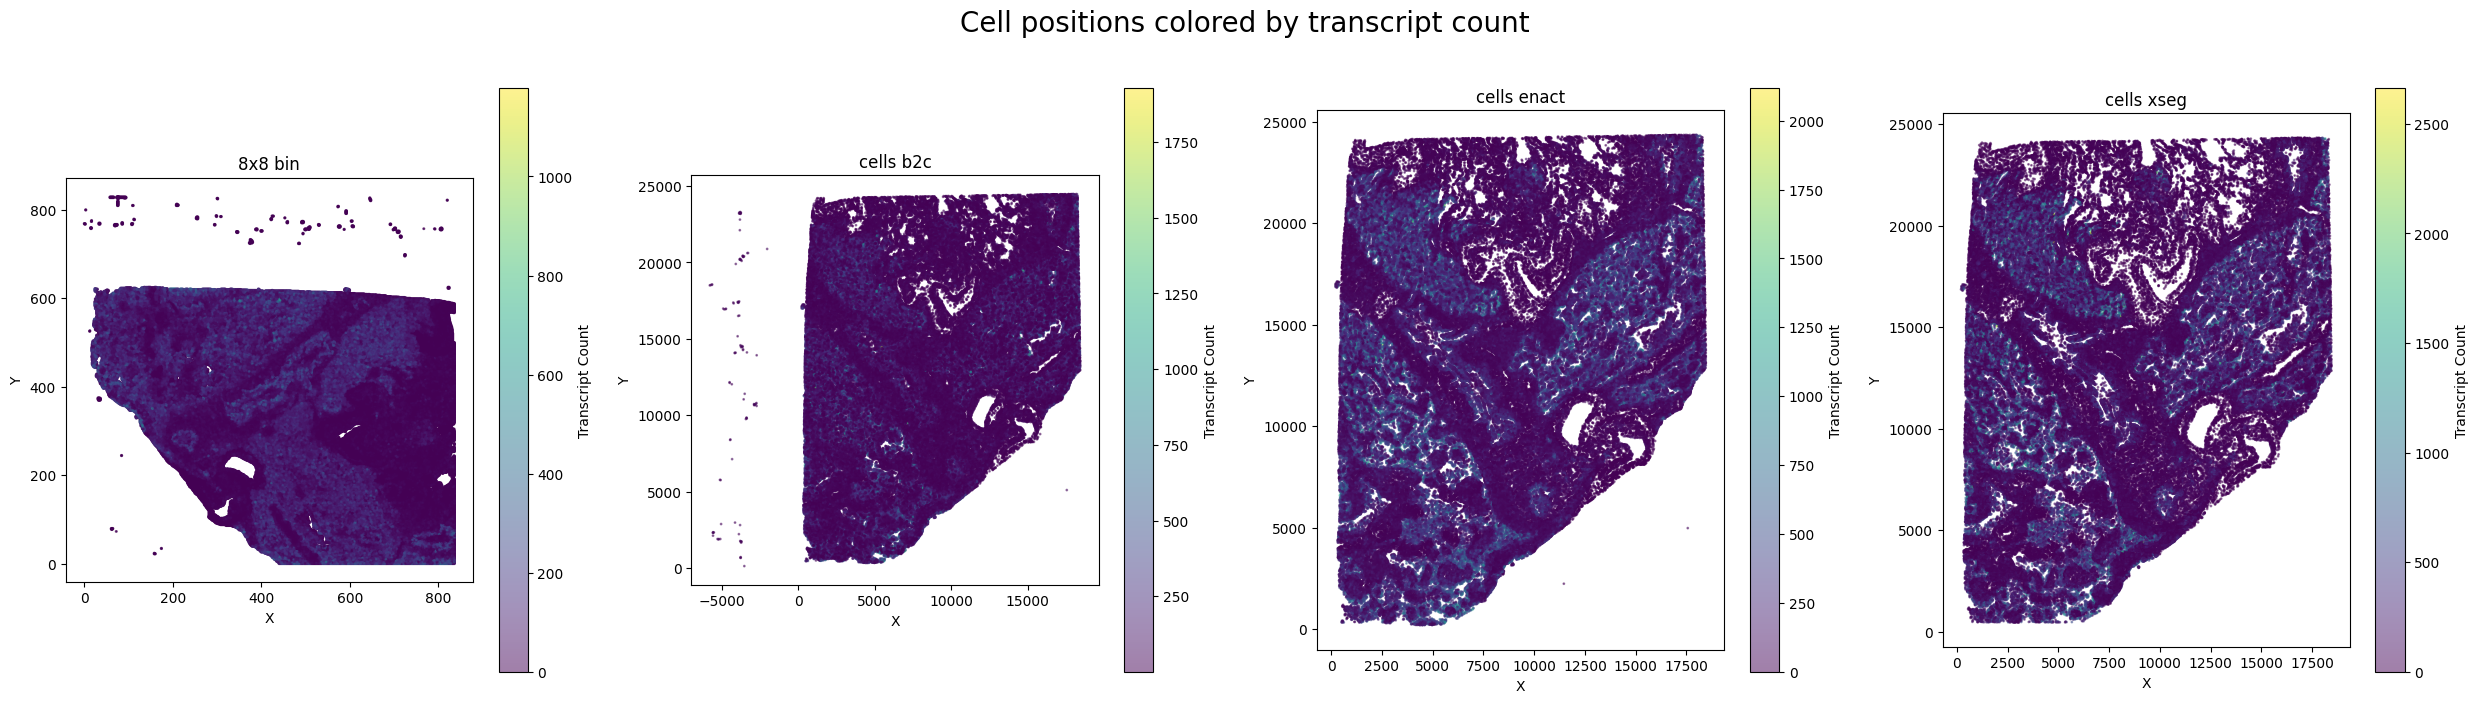

In [21]:
fig, axes = plt.subplots(1, len(cell_keys_p8), figsize=(25, 7), sharex=False, sharey=False)
for ax, key in zip(axes, cell_keys_p8):
    adata = datasets[key]
    coords = adata.obsm['spatial']
    counts = adata.obs['total_counts']
    try:
        xy = coords if isinstance(coords, np.ndarray) else coords.values
        x, y = xy[:, 0], xy[:, 1]
    except Exception:
        x, y = coords['cell_x'].values, coords['cell_y'].values

    sc_plot = ax.scatter(x, y, c=counts, s=1, alpha=0.5, cmap='viridis')
    ax.set_title(key)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')
    plt.colorbar(sc_plot, ax=ax, label='Transcript Count')
fig.suptitle("Cell positions colored by transcript count", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Plotting cells b2c...
Plotting cells enact...
Plotting cells xseg...


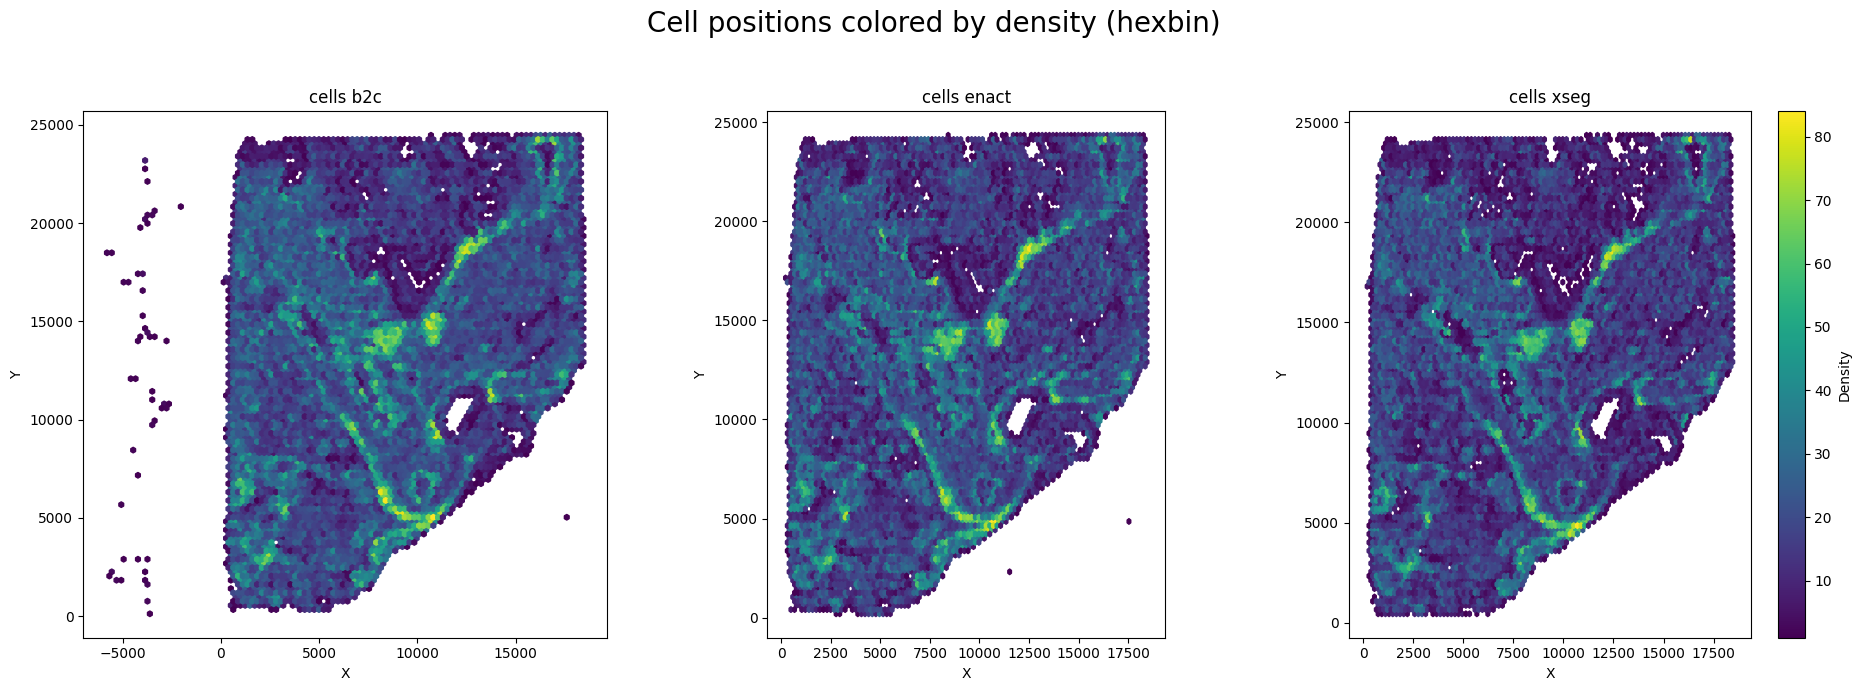

In [18]:
fig, axes = plt.subplots(1, len(cell_keys), figsize=(19, 7), sharex=False, sharey=False)
for ax, key in zip(axes, cell_keys):
    adata = datasets[key]
    coords = adata.obsm['spatial']
    try:
        xy = coords if isinstance(coords, np.ndarray) else coords.values
        x, y = xy[:, 0], xy[:, 1]
    except Exception:
        x, y = coords['cell_x'].values, coords['cell_y'].values

    print(f"Plotting {key}...")
    hb = ax.hexbin(x, y, gridsize=100, cmap='viridis', mincnt=1)
    ax.set_title(key)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')
    if ax == axes[2]:
        plt.colorbar(hb, ax=ax, label='Density')

fig.suptitle("Cell positions colored by density (hexbin)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


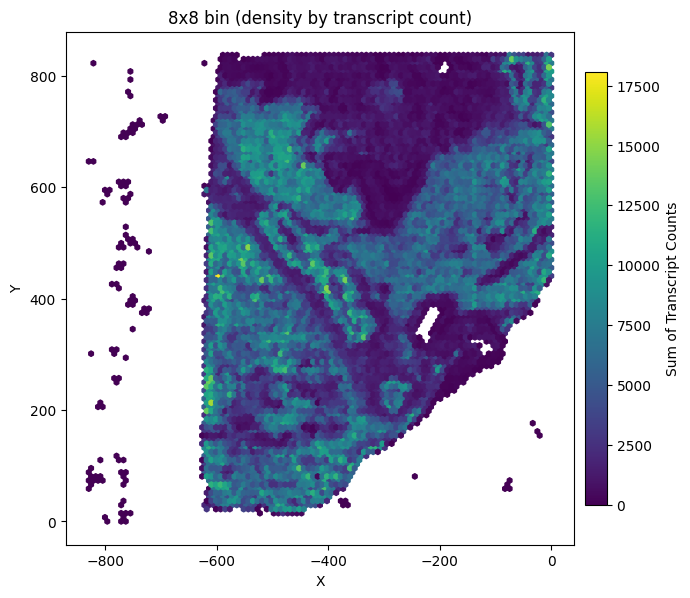

In [47]:
fig, ax = plt.subplots(figsize=(7, 7))
coords = datasets['8x8 bin'].obsm['spatial']
xy = coords if isinstance(coords, np.ndarray) else coords.values
x, y = xy[:, 0], xy[:, 1]
transcript_counts = datasets['8x8 bin'].obs['total_counts'].values

hb = ax.hexbin(-y, x, C=transcript_counts, gridsize=100, cmap='viridis', mincnt=1, reduce_C_function=np.sum)
ax.set_title('8x8 bin (density by transcript count)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')
# Make the colorbar smaller by setting its fraction and pad
plt.colorbar(hb, ax=ax, label='Sum of Transcript Counts', fraction=0.04, pad=0.02)

plt.tight_layout()
plt.show()


Here I recommend checking out the Anndata report app in sushi to get similar results as above in an automated way, including a final html report.


In [48]:
adata_bin_8

AnnData object with n_obs × n_vars = 411242 × 18085
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden_0.5', 'leiden_0.7', 'leiden_1.0', 'leiden_1.2', 'leiden_1.5', 'leiden_clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden_0.5', 'leiden_0.7', 'leiden_1.0', 'leiden_1.2', 'leiden_1.5', 'leiden_clusters_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

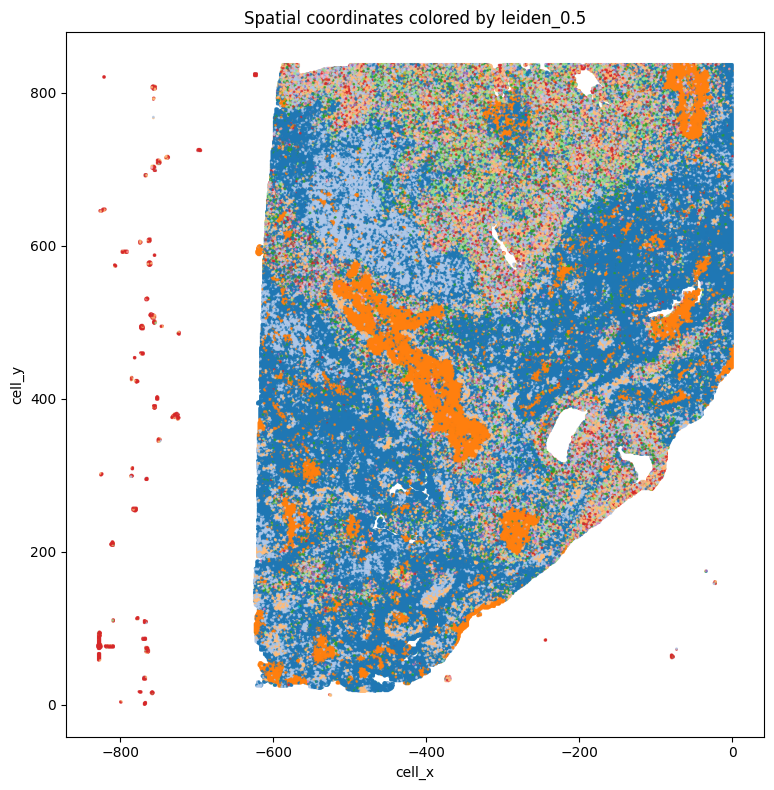

In [ ]:
plt.figure(figsize=(8, 8))
coords = adata_bin_8.obsm['spatial']
if isinstance(coords, np.ndarray):
    x, y = coords[:, 0], coords[:, 1]
else:
    x, y = coords['cell_x'].values, coords['cell_y'].values

leiden_labels = adata_bin_8.obs['leiden_0.5'].astype(int)
scatter = plt.scatter(-y, x, c=leiden_labels, s=1, cmap='tab20', alpha=0.7, vmin=0, vmax=52)
plt.xlabel('cell_x')
plt.ylabel('cell_y')
plt.title('Spatial Coordinates Colored by Leiden Cluster')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()